In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [4]:
f(3.0)

20.0

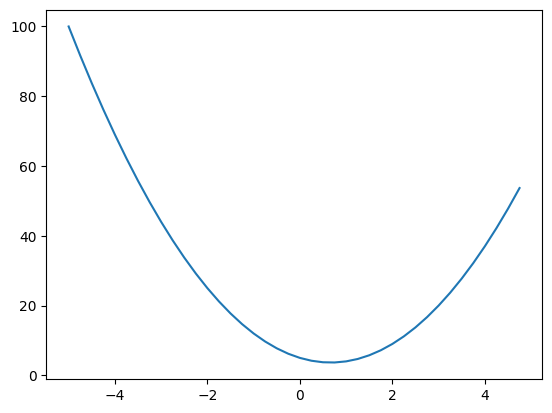

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.00001

# input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [165]:
class Value:

  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    # chain rule
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [110]:
a = Value(2.0)
b = Value(4.0)

a / b
a - b


Value(data=-2.0)

In [21]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    vid = str(id(n))
    dot.node(name = vid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
    if n._op:
      dot.node(name = vid + n._op, label = n._op)
      dot.edge(vid + n._op, vid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

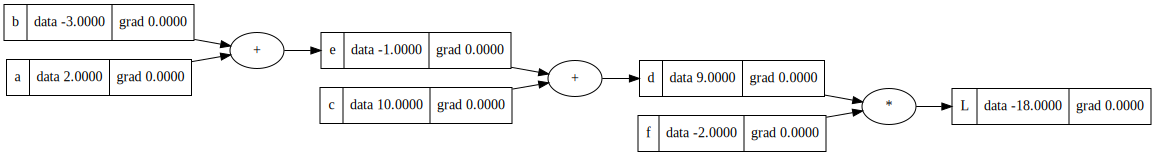

In [11]:
draw_dot(L)

In [12]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [13]:
def lol():
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a + b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L1 = L.data

  a = Value(2.0 + h, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a + b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


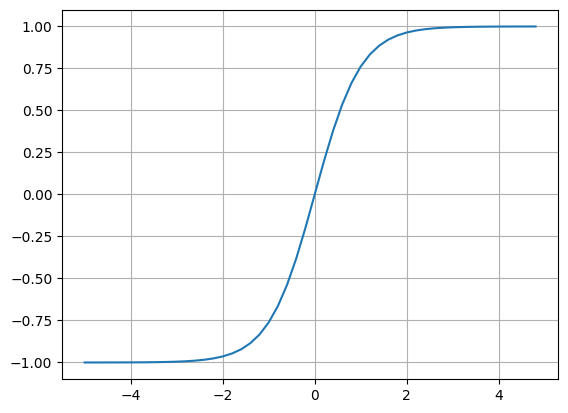

In [14]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [111]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.88, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()


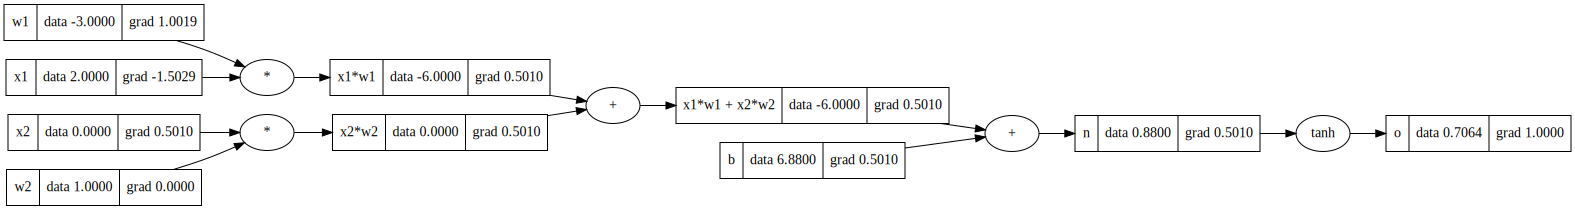

In [112]:
draw_dot(o)

In [142]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.88, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# ---
o.label = 'o'
o.backward()


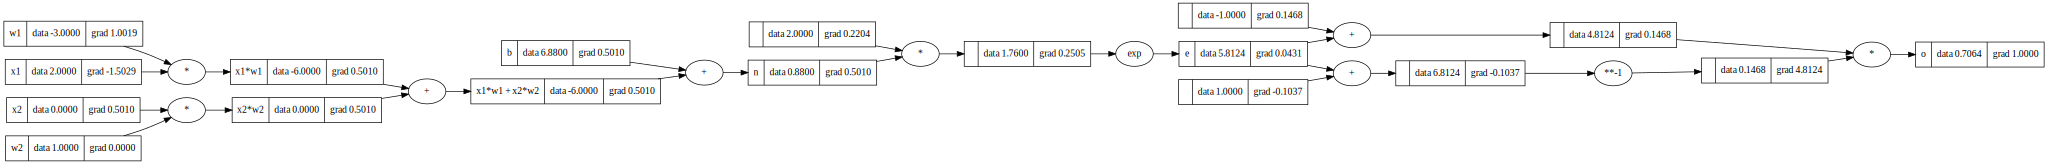

In [143]:
draw_dot(o)

In [80]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [41]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [32]:
1 - o.data**2

0.5009717437695084

In [ ]:
# o = tanh(n)
# do / dn = 1 - o**2

In [83]:
o.grad = 1.0



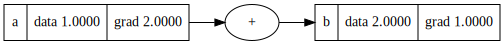

In [93]:
a = Value(1.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [144]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7064193777288968
---
x2 0.5009716627691182
w2 0.0
x1 -1.5029149883073547
w1 1.0019433255382364


In [147]:
import random

In [174]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]


  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [238]:
x = [2.0 , 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.812747823618313)

In [239]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [244]:
# Top NN bugs
# 1) not overfit a single batch first
# 2) forgot to toggle train/eval mode for the net
# 3) forgot to zero_grad() before backward
# 4) pass softmaxed outputs to a loss that expects raw logits
# 5) did not use bias = False for Linear/Conv2D layer when use BatchNorm or conversely forget to include it for the output layer
# 6) taking view and permute are the same thing ( & incorrectly using view)

for k in range(100):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.03759270991982505
1 0.035947476234348796
2 0.03442452356437291
3 0.03301145692539298
4 0.03169744588718634
5 0.030472990714797903
6 0.029329728584007123
7 0.02826027217672482
8 0.027258074588965467
9 0.02631731573727185
10 0.02543280642114416
11 0.02459990695721997
12 0.02381445789616887
13 0.023072720803270205
14 0.0223713274568358
15 0.02170723611654322
16 0.021077693752760446
17 0.020480203320650824
18 0.019912495318937594
19 0.0193725030002182
20 0.018858340703501418
21 0.018368284864800813
22 0.01790075733177353
23 0.01745431066640642
24 0.017027615167905973
25 0.016619447388052898
26 0.016228679944804824
27 0.015854272468037348
28 0.015495263534956867
29 0.015150763472669384
30 0.014819947922269202
31 0.01450205207314069
32 0.014196365488356965
33 0.013902227452464019
34 0.013619022781837183
35 0.013346178045429754
36 0.013083158150296327
37 0.012829463251925063
38 0.01258462595429783
39 0.01234820876882407
40 0.012119801804958447
41 0.01189902066850155
42 0.01168550454635660

In [245]:
ypred

[Value(data=0.9683516080221468),
 Value(data=-0.9680436474846214),
 Value(data=-0.9510931269207261),
 Value(data=0.9657273288826834)]